In [1]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate,false_positive_rate,true_positive_rate,false_negative_rate,true_negative_rate
# torch
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# import defined functions and classes
from tools.imgloader import loader
from tools.clf import PyTorchClassifier 
from tools.plot import plotROC, heatmap_joint_dist

# How to use this toolkit repository
Note: We provide some code examples on data loading, classifier building and training, which hopefully could help you spend less time on this part of coding. Please note that you don't have to follow any of the codes here, and you are free to come up with your own implementations. 

Spot anything wrong or have any suggestions? Feel free to contact me and I will try to update it as soon as possible. (email: ninwe[at]dtu.dk)

In this notebook, we will show examples of:
1. Load the dataset and avoid the pitfall in joint-distribution imbalance.
2. A simple resnet implementation with the dataset.
3. Tricks to use some mitigation methods in `FairLearn` with multi-D input.

## 1. Dataloading
### Method 1: load the dataset with `loader` function
Notice that a random train-test split might result in data imbalance, especially when there are multiple attributes that we care about. E.g. P(disease)_train = P(disease)_test, P(female)_train = P(female)_test, but P(disease,female)_train might not equal to P(disease,female)_test.
For the first part of this exercise, to keep the evaluation easy to analyse, it's better to rule out the other possible causes of bias, like hidden imbalance in the test set.
`loader` function takes that into account. If you build the dataloader yourself, please note this potential pitfall.

Run:

`... = loader(img_dir=your_img_dir,device=device,default_split=True)`

### Method 2: directly load the prepared balanced split
To make things easier, you can also loader the prepared balanced split by run:

`... = loader(img_dir=your_img_dir,device=device,default_split=False,random_seed=your_random_seed)`

In [3]:
X_train, y_train, a_train, X_test, y_test, a_test = loader(img_dir=your_img_dir,
                                                           device=device,
                                                           default_split=True)

loading DDI dataset
Finish loading.
#train: 523
#test: 133


In [45]:
# X_train, y_train, a_train, X_test, y_test, a_test = loader(img_dir=your_img_dir,
#                                                            device=device,
#                                                            default_split=False,
#                                                            random_seed=your_random_seed)

loading DDI dataset
Finish loading.
#train: 523
#test: 133


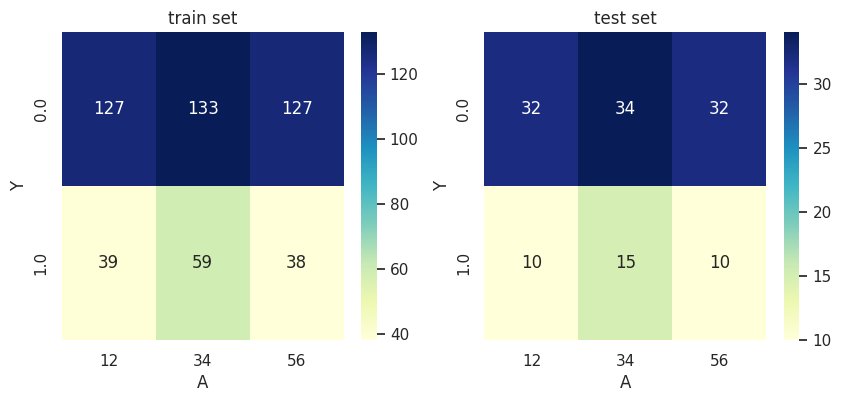

In [53]:
# validate the joint dist are the same across splits
heatmap_joint_dist(y_train,a_train,y_test,a_test)

## 2. Train a ResNet
A torch based classifiier `PyTorchClassifier` is provided if needed. Only implement `resnet50` and `CrossEntropyLoss`.

In [60]:
classifier = PyTorchClassifier(model_type='resnet',  # resnet
                               loss_func_type = 'CE', # CrossEntropyLoss 
                               weights=torch.tensor([1.0,3.0]), # weight on different class
                               num_classes=2,
                               device=device,
                               epochs=50,
                               batch_size=16,
                               lr=1e-5,
                               weight_decay=0.05,
                               )

In [40]:
# fitting
classifier.fit(X_train, y_train)

In [62]:
# Predictions and assessment
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)
y_prob = y_prob[:,1] # probability of being class 1 (malignant in our case)

In [41]:
# Assess fairness of the baseline model
mf = MetricFrame(metrics={'accuracy': accuracy_score,
                        #   '...':...,
                         },
                 y_true=y_test.cpu(),
                 y_pred=y_pred,
                 sensitive_features=a_test.cpu().detach().numpy())

print("Baseline model fairness metrics:")
print(mf.by_group)

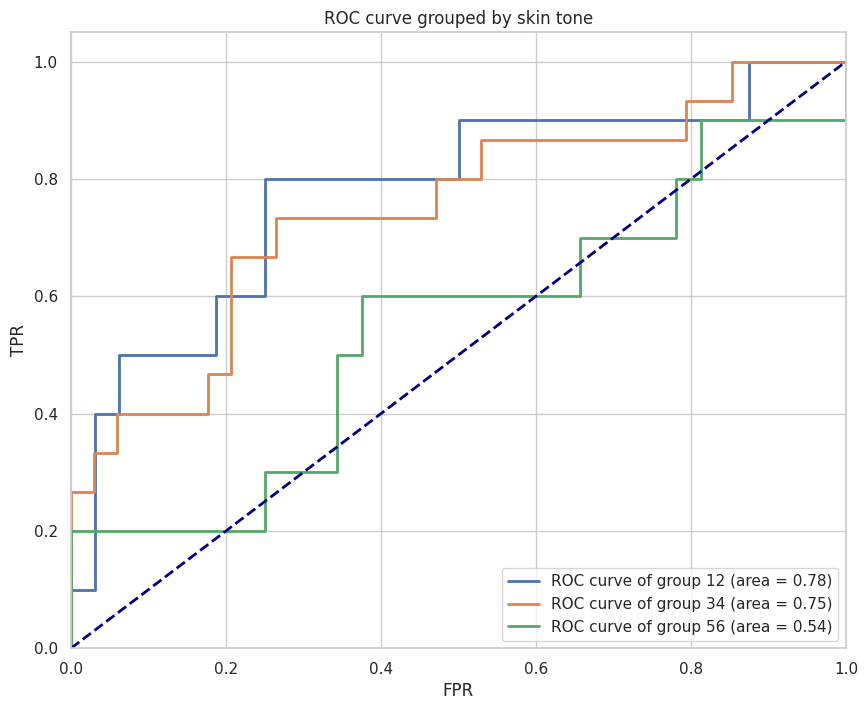

In [64]:
plotROC(...)

## 3. Tricks to use the mitigation methods from `FairLearn`
`FairLearn` provides methods for bias mitigation, please check this [page](https://fairlearn.org/main/user_guide/mitigation/index.html) for more information. As `FairLearn` was designed and tested mostly on tabular data, some mitigation methods it provided, e.g. [`ThresholdOptimizer`](https://fairlearn.org/main/user_guide/mitigation/postprocessing.html#threshold-optimizer), has restrictions on input data dimentions (D <=2 ), which is limited by vairiable checking functions in `sklearn`. To get around this restriction:
### Method 1: reshape the input
Reshape `X` to 2D before feed into classifer, and reshape it back before training. See the implementation in `PyTorchClassifier2DInput`.
### Method 2: separate feature extractor and classifier
Another solution is to separate the classifier into A) a feature extractor (or an encoder), $z = f(X)$, where $z$ is a vector; B) a classifier, $y = g(z)$, where $y$ is the (probabilities of) classes. 

The second method is not implemented in this toolkit.

In [4]:
from tools.clf import PyTorchClassifier2DInput 

classifier = PyTorchClassifier2DInput(model_type='resnet',  # resnet
                                        loss_func_type = 'CE', # CrossEntropyLoss 
                                        weights=torch.tensor([1.0,3.0]), # weight on different class
                                        num_classes=2,
                                        device=device,
                                        epochs=50,
                                        batch_size=16,
                                        lr=1e-5,
                                        weight_decay=0.05,
                                        )

In [42]:
X_train_2D = torch.reshape(X_train,(X_train.shape[0],-1))
classifier.fit(X_train_2D, y_train)

In [6]:
X_test_2D = torch.reshape(X_test,(X_test.shape[0],-1))
# Predictions and assessment
y_pred = classifier.predict(X_test_2D)
y_prob = classifier.predict_proba(X_test_2D)
y_prob = y_prob[:,1]

In [43]:
# Assess fairness of the baseline model
mf = MetricFrame(metrics={'accuracy': accuracy_score,
                        #   '...':...,
                          },
                 y_true=y_test.cpu(),
                 y_pred=y_pred,
                 sensitive_features=a_test.cpu().detach().numpy())

print("Baseline model fairness metrics:")
print(mf.by_group)

Apply the mitigation methods

In [18]:
from fairlearn.postprocessing import ThresholdOptimizer
to = ThresholdOptimizer(
                   estimator=classifier,
                   constraints="false_negative_rate_parity",
                   objective="balanced_accuracy_score",
                   prefit=True,
                   predict_method='predict_proba')


# Fit the ExponentiatedGradient model
to.fit(X_train_2D.cpu(), y_train.cpu(), sensitive_features=a_train.cpu())

# Make predictions
y_pred_fair = to.predict(X_test_2D.cpu(),sensitive_features=a_test.cpu())

In [44]:
# Assess fairness
mf = MetricFrame(metrics={'accuracy': accuracy_score,
                        #   '...':...,
                          },
                 y_true=y_test.cpu(),
                 y_pred=y_pred_fair,
                 sensitive_features=a_test.cpu().detach().numpy())

print("Bias mitigation, fairness metrics:")
print(mf.by_group)